<a href="https://colab.research.google.com/github/JYL480/RAGNutri/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary packages
# Perform Google Colab installs (if running in Google Colab)
import os


print("[INFO] Running in Google Colab, installing requirements.")
!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models, helps to give dense vectors formed from the words
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space), reduce the size of the weights!
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 

In [ ]:
# Testing the embeddings from the senetances
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# List of sentences
sentences = ["This is an example sentence", "Each sentence is converted"]

# Generate embeddings
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding[:5]}...")  # Print first 5 values of the embedding


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: This is an example sentence
Embedding: [0.0676569  0.06349589 0.04871311 0.07930496 0.03744804]...
Sentence: Each sentence is converted
Embedding: [ 0.08643857  0.10276262  0.00539455  0.00204445 -0.00996337]...


In [ ]:
# Download the PDF from online first!

import os
import requests

# We will create a file to store this in our directory
url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

file_name = "human-nutrition-text.pdf"

if os.path.exists(file_name):
  print("File already exists!")

else:
  print("Downloading file...")
  response = requests.get(url)
  if response.status_code == 200: # 200 means it is a success, you can search online!
  # Note that when you want to download from a URL it has to be the download URL!!
    with open(file_name, "wb") as f:
      f.write(response.content)
      print("File Downloaded")
  else:
    print("Failed to download file")

File Downloaded


In [ ]:
# Here we will preprocess that data!
#  note that are a lot of packages avaialble to read! But this is the best in terms of the data used!
def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

In [ ]:
# Now we deal with reading part!

import fitz # PyMuPDF, note both are the same thing, it fitz is just another alias for PyMuPDF
from tqdm.auto import tqdm

# Nota that this will accept an input of the path to the pdf
# and then return a list of dictionary of texts that have been cleaned!!
def open_and_read_pdf(pdf_path) -> list[dict]:
  doc = fitz.open(pdf_path)
  # you will initialise a list, so what you will return a list of dictionaries!!
  # This is a standard to do because list of dictionaries are very good with data manipulation!
  pages_and_texts = []
  for page_num, page in tqdm(enumerate(doc)):
    # we get the text!
    text = page.get_text()
    # we will clean it with text_formatter()
    text = text_formatter(text)
    # We append the text to the list
    pages_and_texts.append({"page_number": page_num - 41,  # adjust page numbers since our PDF starts on page 42
                              "page_char_count": len(text),
                              "page_word_count": len(text.split(" ")),
                              "page_sentence_count_raw": len(text.split(". ")),
                              "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                              "text": text})
  return pages_and_texts

pdf_path = "human-nutrition-text.pdf"
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


In [ ]:
import spacy

# Load a pre-trained model
nlp = spacy.load("en_core_web_sm")

# Process some text
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Print the named entities
for ent in doc.ents:
    print(ent.text, ent.label_)

# Print the part-of-speech tags
for token in doc:
    print(token.text, token.pos_, token.dep_)


Apple ORG
U.K. GPE
$1 billion MONEY
Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN dobj
startup NOUN dep
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")
doc = nlp("This is a sentence. This is another sentence.")
assert len(list(doc.sents)) == 2
list(doc.sents)

[This is a sentence., This is another sentence.]

In [ ]:
pages_and_texts[50]

{'page_number': 9,
 'page_char_count': 1320,
 'page_word_count': 215,
 'page_sentence_count_raw': 4,
 'page_token_count': 330.0,
 'text': 'Minerals  Major Functions  Macro  Sodium  Fluid balance, nerve transmission, muscle contraction  Chloride  Fluid balance, stomach acid production  Potassium  Fluid balance, nerve transmission, muscle contraction  Calcium  Bone and teeth health maintenance, nerve transmission,  muscle contraction, blood clotting  Phosphorus  Bone and teeth health maintenance, acid-base balance  Magnesium  Protein production, nerve transmission, muscle  contraction  Sulfur  Protein production  Trace  Iron  Carries oxygen, assists in energy production  Zinc  Protein and DNA production, wound healing, growth,  immune system function  Iodine  Thyroid hormone production, growth, metabolism  Selenium  Antioxidant  Copper  Coenzyme, iron metabolism  Manganese  Coenzyme  Fluoride  Bone and teeth health maintenance, tooth decay  prevention  Chromium  Assists insulin in glucos

In [ ]:
# Now we want to split all the texts into sentences for all the pages using the spaCy sentencizer!

# So you can for loop the list of dictionaries and then pass through the pipeline!

for item in tqdm(pages_and_texts):
  # we will add a new key = sentnces within our list of dictioanries!
  item["sentences"] = list(nlp(item["text"]).sents) # we will start the sentencizer!! with .sents!

  # Now we would have to convert the data type from spaCy to string
  item["sentences"] = [str(sentences) for sentences in item["sentences"]]

  # We will add another new key to count the number of sentneces within each pages
  item["page_sentence_count_spacy"] = len(item["sentences"])


  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
pages_and_texts[50]

{'page_number': 9,
 'page_char_count': 1320,
 'page_word_count': 215,
 'page_sentence_count_raw': 4,
 'page_token_count': 330.0,
 'text': 'Minerals  Major Functions  Macro  Sodium  Fluid balance, nerve transmission, muscle contraction  Chloride  Fluid balance, stomach acid production  Potassium  Fluid balance, nerve transmission, muscle contraction  Calcium  Bone and teeth health maintenance, nerve transmission,  muscle contraction, blood clotting  Phosphorus  Bone and teeth health maintenance, acid-base balance  Magnesium  Protein production, nerve transmission, muscle  contraction  Sulfur  Protein production  Trace  Iron  Carries oxygen, assists in energy production  Zinc  Protein and DNA production, wound healing, growth,  immune system function  Iodine  Thyroid hormone production, growth, metabolism  Selenium  Antioxidant  Copper  Coenzyme, iron metabolism  Manganese  Coenzyme  Fluoride  Bone and teeth health maintenance, tooth decay  prevention  Chromium  Assists insulin in glucos

In [ ]:
# Lets EDA again with the new keys!
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


- There is an average of ~10 sentences per page

- Note that difference between raw and spacy package!!
- We will use the spacy as it should be more accurate than the raw method of split(".")

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
import random
random.sample(pages_and_texts, k=1)

[{'page_number': 622,
  'page_char_count': 1647,
  'page_word_count': 283,
  'page_sentence_count_raw': 12,
  'page_token_count': 411.75,
  'text': 'Diet, Supplements, and Chelated Supplements  In general, calcium supplements perform to a lesser degree than  dietary sources of calcium in providing many of the health benefits  linked to higher calcium intake. This is partly attributed to the fact  that dietary sources of calcium supply additional nutrients with  health-promoting activities. It is reported that chelated forms of  calcium supplements are easier to absorb as the chelation process  protects the calcium from oxalates and phytates that may bind with  the calcium in the intestines. However, these are more expensive  supplements and only increase calcium absorption up to 10 percent.  In people with low dietary intakes of calcium, calcium supplements  have a negligible benefit on bone health in the absence of a vitamin  D supplement. However, when calcium supplements are taken a

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
pages_and_texts[248]["sentence_chunks"]

[['activity level are determinants of salt sensitivity.',
  'African Americans,  women, and overweight individuals are more salt-sensitive than  others.',
  'Also, if hypertension runs in a person’s family, that person  is more likely to be salt-sensitive.',
  'Because reducing dietary salt  intake will not work for everyone with hypertension or a risk for  developing the condition, there are many opponents of reducing  dietary salt intake at the national level.',
  'Among such opponents is  the Salt Institute, a nonprofit trade organization that states, “No  evidence demonstrates that current salt intake levels lead to worse  health outcomes such as more heart attacks or higher  cardiovascular mortality.',
  '”8  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.',
  '\xa0 These activities are  available in the web-based textbook and not available in the  downloadable vers

In [ ]:
pages_and_chunks[344]

{'page_number': 207,
 'sentence_chunk': 'activity level are determinants of salt sensitivity. African Americans, women, and overweight individuals are more salt-sensitive than others. Also, if hypertension runs in a person’s family, that person is more likely to be salt-sensitive. Because reducing dietary salt intake will not work for everyone with hypertension or a risk for developing the condition, there are many opponents of reducing dietary salt intake at the national level. Among such opponents is the Salt Institute, a nonprofit trade organization that states, “No evidence demonstrates that current salt intake levels lead to worse health outcomes such as more heart attacks or higher cardiovascular mortality.”8 Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 28.0 | Text: Fluid balance refers to maintaining the distribution of water in the body. 386 | Protein’s Functions in the Body
Chunk token count: 17.25 | Text: Updated March 2010. Accessed November 22, 2017. MyPlate Planner | 757
Chunk token count: 22.75 | Text: Building a protein involves three steps: transcription, translation, Defining Protein | 369
Chunk token count: 25.0 | Text: http:/ /www.ajcn.org/content/87/1/64.long. Accessed September 22, 2017. 554 | Water-Soluble Vitamins
Chunk token count: 25.25 | Text: http:/ /www.ncbi.nlm.nih.gov/ pubmed/3966752?dopt=Abstract. Accessed November 22, 2017. 618 | Calcium


In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[10]

{'page_number': -29,
 'sentence_chunk': 'Part\xa0VII.\xa0Chapter 7. Alcohol Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 431 Alcohol Metabolism University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 436 Health Consequences of Alcohol Abuse University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 442 Health Benefits of Moderate Alcohol Intake University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 448 Part\xa0VIII.\xa0Chapter 8. Energy Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 453 The Atom University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 460 Weight Management University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 472',
 'chunk

In [ ]:
df = pd.DataFrame(pages_and_chunks_over_min_token_len)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1680.00,1680.00,1680.00,1680.00
mean,580.64,799.38,122.69,199.85
std,349.77,415.20,66.45,103.80
min,-39.00,122.00,10.00,30.50
25%,277.00,422.00,62.00,105.50
50%,579.50,818.00,125.50,204.50
75%,889.25,1144.00,177.00,286.00
max,1166.00,1831.00,297.00,457.75


In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
# %%time

# # Send the model to the GPU
# embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# # Create embeddings one by one on the GPU
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [ ]:
%%time

# Embed all texts in batches
# Better to do it in this way, where you embed the whole list!!!
# Note the batch_size = 32 is default as per link: https://www.sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html?highlight=encode#sentence_transformers.SentenceTransformer.encode
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 20.3 s, sys: 52.1 ms, total: 20.4 s
Wall time: 23.5 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 30.9 s, sys: 240 ms, total: 31.2 s
Wall time: 32 s


## There is a difference between the non batch and batch way!!
- Without the batch, you can add each sentence chunk embedding into their respective embeddings
- With batch, you will batch all the chunk all at once in a single list!
- So you cant get the embeddings for each respective page.

In [ ]:
pages_and_chunks_over_min_token_len[1]

{'page_number': -38,
 'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
 'chunk_char_count': 210,
 'chunk_word_count': 30,
 'chunk_token_count': 52.5,
 'embedding': array([ 5.52156419e-02,  5.92139773e-02, -1.66167244e-02, -2.04602741e-02,
         6.92423135e-02,  3.51345278e-02, -1.87620409e-02,  3.21568809e-02,
         7.78691173e-02, -8.06512590e-03,  2.60771997e-02,  1.17888609e-04,
         2.36337036e-02,  6.99446909e-03,  1.73927401e-06, -3.82589269e-03,
         3.45730293e-03,  1.16405431e-02,  1.01687759e-02,  4.95471433e-02,
        -5.18356562e-02,  1.88298244e-02,  4.51909862e-02,  4.23134826e-02,
        -4.12122048e-02,  4.93987044e-03,  3.25199515e-02, -1.81734804e-02,
         8.84534046e-03, -6.44744039e-02, -5.04505774e-03,  1.74673721e-02,
        -1.65689772e-03, -8.50823671e-02,  2.4

In [ ]:
# save the embedding file!
text_chunks_and_embedding_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embedding_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


## RAG part

In [ ]:
#  Use this if you are want to get the embedding values from the csv file directly without any prior code

# import random

# import torch
# import numpy as np
# import pandas as pd

# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Import texts and embedding df
# text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# # Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
# text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# # Convert texts and embedding df to list of dicts
# pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# # Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
# embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
# embeddings.shape

In [ ]:
# Lets convert the embeddings in a list of list into tensors!
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
# Rmb that there are some data type things we have to take note of!!
# RMB numpu default to float64!!

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)

### You will use dot product aka cosine similarity to determine how similar the qeuery and texts are!!
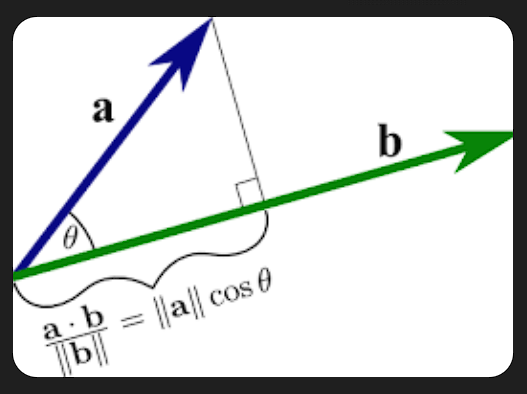


- Rmb how there orthogonal as well! If A orthogonal to B, the dot product == 0
- If the dot product is > 0, meaning A is at an angle, and pointnig in the same direction!!

In [ ]:
# Sementic search!!!

from sentence_transformers import util

# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "carbohydrates functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)
print(f"Query shape: {query_embedding.shape}")
print(f"embeddings shape: {embeddings.shape}")

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: carbohydrates functions
Query shape: torch.Size([768])
embeddings shape: torch.Size([1680, 768])
Time take to get scores on 1680 embeddings: 0.02354 seconds.


torch.return_types.topk(
values=tensor([0.7909, 0.7383, 0.7062, 0.6547, 0.6418], device='cuda:0'),
indices=tensor([381, 389, 390, 349,  44], device='cuda:0'))

In [ ]:
dot_scores = util.dot_score(a=query_embedding, b=embeddings)
dot_scores[0]

tensor([0.2672, 0.3113, 0.2786,  ..., 0.3828, 0.2707, 0.2321], device='cuda:0')

In [ ]:
pages_and_chunks_over_min_token_len[381]

{'page_number': 253,
 'sentence_chunk': 'The Functions of Carbohydrates in the Body UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM There are five primary functions of carbohydrates in the human body. They are energy production, energy storage, building macromolecules, sparing protein, and assisting in lipid metabolism. Energy Production The primary role of carbohydrates is to supply energy to all cells in the body. Many cells prefer glucose as a source of energy versus other compounds like fatty acids. Some cells, such as red blood cells, are only able to produce cellular energy from glucose. The brain is also highly sensitive to low blood-glucose levels because it uses only glucose to produce energy and function (unless under extreme starvation conditions). About 70 percent of the glucose entering the body from digestion is redistributed (by the liver) back into the blood for use by other tissues. Cells that require energy remove th

In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.7 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

# Generate some random data (e.g., 10000 vectors of dimension 128)
d = 128  # dimension
nb = 10000  # database size
nq = 10  # number of queries

np.random.seed(1234)  # make reproducible
database = np.random.random((nb, d)).astype('float32')
queries = np.random.random((nq, d)).astype('float32')

# Create a FAISS index
index = faiss.IndexFlatL2(d)  # L2 distance metric
index.add(database)  # Add the database vectors to the index

# Search the index for the nearest neighbor of each query
k = 5  # number of nearest neighbors to retrieve
distances, indices = index.search(queries, k)  # Search

print("Indices of nearest neighbors:\n", indices)
print("Distances of nearest neighbors:\n", distances)


Indices of nearest neighbors:
 [[7548 5874 4044 1573 2826]
 [8619 2762 2862  417 6717]
 [6059 5596 1617  106 7259]
 [7167 6353 8302 4062 1648]
 [5531 9262 2933 5512 7722]
 [2009 2817 5837 2427 1566]
 [4053 1280 6548 1146 6788]
 [4033 2683 8931 8101 2308]
 [8136 8524 1866 6305 5270]
 [1479  288 1932 3717 8357]]
Distances of nearest neighbors:
 [[14.120587  14.428285  14.519494  14.67854   14.977838 ]
 [14.76997   15.277809  15.826491  15.894087  16.032444 ]
 [14.9966    15.646383  15.671434  15.703394  16.039843 ]
 [13.78844   13.872477  14.549909  14.625788  14.823553 ]
 [13.655875  13.713435  13.981211  14.27424   14.780529 ]
 [14.410244  15.098836  15.147244  15.461791  15.665555 ]
 [13.797424  13.929192  14.338841  14.43732   14.589758 ]
 [14.458634  14.782125  14.890707  14.950418  14.965881 ]
 [14.865396  15.144062  15.359246  15.390186  15.5297365]
 [14.004693  14.063861  15.396727  15.531064  15.761209 ]]


### Here we will try to baetify our output text just for fun!!

In [ ]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks_over_min_token_len[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks_over_min_token_len[idx]['page_number']}")
    print("\n")

Query: 'carbohydrates functions'

Results:
Score: 0.7909
Text:
The Functions of Carbohydrates in the Body UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD
SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM There are five
primary functions of carbohydrates in the human body. They are energy
production, energy storage, building macromolecules, sparing protein, and
assisting in lipid metabolism. Energy Production The primary role of
carbohydrates is to supply energy to all cells in the body. Many cells prefer
glucose as a source of energy versus other compounds like fatty acids. Some
cells, such as red blood cells, are only able to produce cellular energy from
glucose. The brain is also highly sensitive to low blood-glucose levels because
it uses only glucose to produce energy and function (unless under extreme
starvation conditions). About 70 percent of the glucose entering the body from
digestion is redistributed (by the liver) back into the blood for use by other
tissues. Cells that re

### In the future we can rerank these above semantic search results using another model!
- You can use mixedbread.ai
- https://www.mixedbread.ai/docs

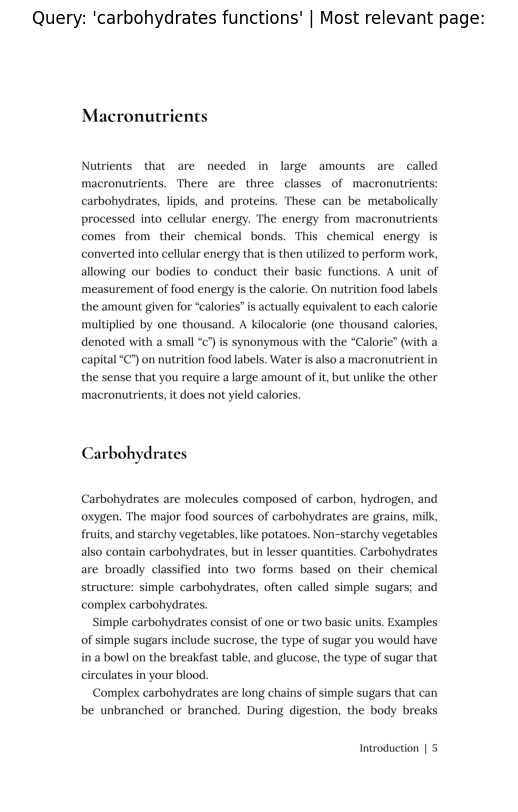

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [ ]:
#  Functionise the above thing
import fitz


# Open PDF and load target page


def test_and_print(page_number: int) -> None:
  pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
  doc = fitz.open(pdf_path)
  page = doc.load_page(page_number+41) # number of page (our doc starts page numbers on page 41)

  # Get the image of the page
  img = page.get_pixmap(dpi=300)

  doc.close()

  # Convert the Pixmap to a numpy array
  img_array = np.frombuffer(img.samples_mv,
                            dtype=np.uint8).reshape((img.h, img.w, img.n))

  # Display the image using Matplotlib
  import matplotlib.pyplot as plt
  plt.figure(figsize=(13, 10))
  plt.imshow(img_array)
  plt.title(f"Query: '{query}' | Most relevant page:")
  plt.axis('off') # Turn off axis
  plt.show()

In [ ]:
#  Now we will do some pipeline of the things we have done so far!!
from sentence_transformers import SentenceTransformer
embeddingModel = SentenceTransformer('all-MiniLM-L6-v2')

def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int = 5,
                                print_time: bool = True):

  query_embedding = model.encode(query, convert_to_tensor=True)
  print(query_embedding.shape)
  # Get the time to do the semantic search, which compares to our source PDF embeddings!
  start_time = timer()
  dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0] # The index zero is just to remove the outer list
  end_time = timer()


  if print_time:
    print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

  # Get the top k scores of the semantic search
  score, indices = torch.topk(dot_scores, n_resources_to_return);
  return score, indices

In [ ]:

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)

torch.Size([768])
[INFO] Time taken to get scores on 1680 embeddings: 0.00013 seconds.
701


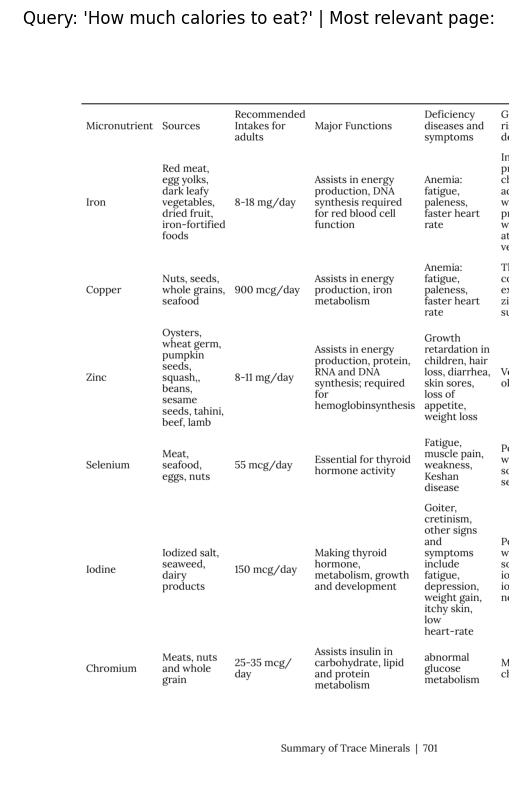

In [ ]:
query = "How much calories to eat?"


score, indices = retrieve_relevant_resources(query, embeddings)
print(indices[1].item())
test_and_print(indices[1].item())

In [ ]:
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results

print_top_results_and_scores(query=query,
                             embeddings=embeddings)

torch.Size([768])
[INFO] Time taken to get scores on 1680 embeddings: 0.00011 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Learning Activities Technology Note: The second edition of the Human Nutrition
Open Educational Resource (OER) textbook features interactive learning
activities.  These activities are available in the web-based textbook and not
available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open
Document). Learning activities may be used across various mobile devices,
however, for the best user experience it is strongly recommended that users
complete these activities using a desktop or laptop computer and in Google
Chrome.   An interactive or media element has been excluded from this version of
the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/
humannutrition2/?p=324   Introduction | 519
Page number: 519


Score: 0.3741
https:/ /jamanetwork.com/journals/jama/ fullarticle/195531. Accessed October 5,
2017. 538 | Fat-So

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

Available GPU memory: 15 GB
GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [ ]:
!nvidia-smi

Wed Jul 24 06:39:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              34W /  70W |   1637MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Based on the above of our avaiable VRAM we will use Gemma-2b-it model!

In [ ]:
torch.cuda.get_device_capability(0)

(7, 5)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,   

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the r

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: water soluble vitamins
torch.Size([768])
[INFO] Time taken to get scores on 1680 embeddings: 0.00311 seconds.


(tensor([0.7893, 0.7625, 0.7386, 0.7099, 0.6996], device='cuda:0'),
 tensor([855, 801, 756, 755, 848], device='cuda:0'))

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
pages_and_chunks_over_min_token_len[1]

{'page_number': -38,
 'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
 'chunk_char_count': 210,
 'chunk_word_count': 30,
 'chunk_token_count': 52.5,
 'embedding': array([ 5.52156419e-02,  5.92139773e-02, -1.66167244e-02, -2.04602741e-02,
         6.92423135e-02,  3.51345278e-02, -1.87620409e-02,  3.21568809e-02,
         7.78691173e-02, -8.06512590e-03,  2.60771997e-02,  1.17888609e-04,
         2.36337036e-02,  6.99446909e-03,  1.73927401e-06, -3.82589269e-03,
         3.45730293e-03,  1.16405431e-02,  1.01687759e-02,  4.95471433e-02,
        -5.18356562e-02,  1.88298244e-02,  4.51909862e-02,  4.23134826e-02,
        -4.12122048e-02,  4.93987044e-03,  3.25199515e-02, -1.81734804e-02,
         8.84534046e-03, -6.44744039e-02, -5.04505774e-03,  1.74673721e-02,
        -1.65689772e-03, -8.50823671e-02,  2.4

In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00014 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and b

## Trying Gemini

In [ ]:
#  Try using gemimni instead?
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai

genai.configure(api_key="")

model = genai.GenerativeModel('gemini-1.5-flash')

In [ ]:
# prompt = "The quick brown fox jumps over the lazy dog."

# Call `count_tokens` to get the input token count (`total_tokens`).
print("total_tokens: ", model.count_tokens(prompt))
# ( total_tokens: 10 )

response = model.generate_content(prompt)



total_tokens:  total_tokens: 1717



In [ ]:
print(response.text)

The Recommended Daily Intake (RDI) for protein varies based on age and gender.  For adult males 19 years and older, the RDI is 56 grams per day, while for adult females 19 years and older, it's 46 grams per day.  



In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Describe the process of digestion and absorption of nutrients in the human body.
RAG answer:
<bos>Sure, here's a summary of the process of digestion and absorption of nutrients in the human body:

**Step 1: The Mouth, Pharynx, and Esophagus**

The process starts even before food enters the mouth. When you feel hungry, your body sends a message to your brain that it is time to eat. Sights and smells influence your body’s preparedness for food. Smelling food sends a message to your brain. Your brain then tells the mouth to get ready, and you start to salivate in preparation for a meal.

**Step 2: The Digestive System**

The digestive system is one of the eleven organ systems of the human body and is composed of several hollow tube-shaped organs including the mouth, pharynx, esophagus, stomach, small intestine, large intestine (colon), rectum, and anus.

**Step 3: Digestion and Absorption of Carbohydrates**

When food enters the mouth, the enzyme salivary amylase initiates the brea

In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.
Answer:

The context does not provide any information about how vitamins and minerals
differ in their roles and importance for health, so I cannot answer this query
from the provided context.
Context items:


[{'page_number': 11,
  'sentence_chunk': 'Vitamins Major Functions Water-soluble Thiamin (B1) Coenzyme, energy metabolism assistance Riboflavin (B2 ) Coenzyme, energy metabolism assistance Niacin (B3) Coenzyme, energy metabolism assistance Pantothenic acid (B5) Coenzyme, energy metabolism assistance Pyridoxine (B6) Coenzyme, amino acid synthesis assistance Biotin (B7) Coenzyme, amino acid and fatty acid metabolism Folate (B9) Coenzyme, essential for growth Cobalamin (B12) Coenzyme, red blood cell synthesis C (ascorbic acid) Collagen synthesis, antioxidant Fat-soluble A Vision, reproduction, immune system function D Bone and teeth health maintenance, immune system function E Antioxidant, cell membrane protection K Bone and teeth health maintenance, blood clotting Vitamin deficiencies can cause severe health problems and even death. For example, a deficiency in niacin causes a disease called pellagra, which was common in the early twentieth century in some parts of America. The common si